In [1]:
## Speaker Modelling
# Rewritten from a MATALB script I wrote as part of an acoustics class

In [1]:
# Imports
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
rho = 1.2
co = 344
Zo = rho*co

In [23]:
diam = 0.107                          # diameter of the driver
Ad = np.pi * diam * diam / 4          # cross sectional area of the driver
a = diam/2

m = 0.009                             # moving mass is 9 grams
Cm = 740e-6                           # compliance in meters / Newton
omres_driver = math.sqrt(1/(m*Cm))    # mech resonance of driver
fres_driver = 1/(2*np.pi) * omres_driver 
Qfact = 2.21                          # quality factor of resonance for driver
Rm = omres_driver * m/Qfact           # obtaining Rm from Qfact 

In [24]:
Vs = 2.83                             # RMS voltage

BL = 5.9                              # BL constant for the driver system
Re = 6                                # resistance in ohms
L = 0.27e-3                           # inductance in Henry
Vencl = 0.0638                        # enclosed volume in m^2

Ca = Vencl / (Zo * co)                # acoustic compliance
Zarp = 885
Zard = 885
Rap_br = 0                            # Ported cabinet
Rap_cl = 1e9                          # Closed cabinet
Rap = Rap_br
ma = 35.21

In [25]:
def Zpar2(Z1,Z2): #computes parallel impedance

    return ((Z1*Z2)/(Z1+Z2))

In [44]:
# Set up frequency space
f = np.logspace(0,3,500)
f_len = len(f) # = 500
Qd = np.zeros((f_len, 1))
Qp = np.zeros((f_len, 1))
Qtot = np.zeros((f_len, 1))
P = np.zeros((f_len, 1), dtype=np.float64 )
i = np.array([1j]) # The imaginary number

In [47]:
# Model speaker response at each frequency
for n in range(f_len):
    
    om = 2*np.pi*f[n]
    i_om = np.multiply(i, om)
    
    F = BL*Vs / (Re + i_om*L)

    Pd = F / Ad; 
    
    Zmd = Rm + i_om*m + 1/(i_om*Cm) + Zpar2((BL*BL/L)/i_om , (BL*BL/Re))
    
    Z1 = Zard + Zmd / (Ad*Ad) 
    Z2 = Zarp + Rap + i_om*ma
    Z3 = 1/(i_om*Ca)
    
    Z1_3 = Z1 + Z3
    Z1_2 = Z1 + Z2
    
    Z_MAT = np.squeeze(np.array([[Z1_3, Z1], [Z1, Z1_2]]))
    P_MAT = np.squeeze(np.array([[Pd],[Pd]]), axis=2)     # squeeze to cut out arbitrary 3rd dimension which makes linalg throw a fit later
    
    # mldivide in MATLAB: Q_MAT = Z_MAT \ P_MAT;
    # NumPy's alternatives arent as good as MatLab's implementation, but they should work
    Q_MAT = np.linalg.lstsq(Z_MAT, P_MAT, rcond=-1)[0]

    
    Qd[n] = Q_MAT[0] + Q_MAT[1]  # Flow through diaphram
    Qp[n] = - Q_MAT[1]           # Flow through port

    Qtot[n] = Qd[n] + Qp[n]      # Total flow

    P[n] = (i_om * rho * Qtot[n]) / (4*np.pi) # Pressure : TODO 1-28: figure out why this is always zero?

    
print(np.count_nonzero(P))

0


<ipython-input-47-39ff125bb107>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  Qd[n] = Q_MAT[0] + Q_MAT[1]  # Flow through diaphram
<ipython-input-47-39ff125bb107>:29: ComplexWarning: Casting complex values to real discards the imaginary part
  Qp[n] = - Q_MAT[1]           # Flow through port
<ipython-input-47-39ff125bb107>:33: ComplexWarning: Casting complex values to real discards the imaginary part
  P[n] = (i_om * rho * Qtot[n]) / (4*np.pi) # Pressure : TODO 1-28: figure out why this is always zero?


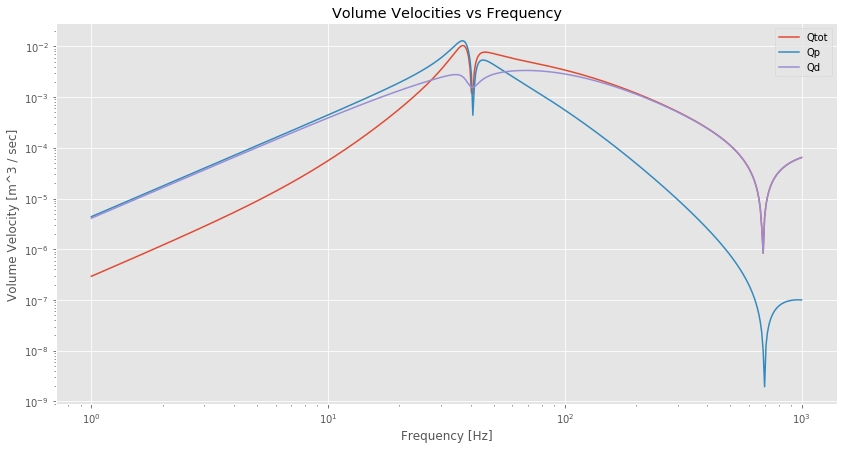

In [48]:
# Plot Volume Velocities
with plt.style.context('ggplot'): # Set style to be like R
    
    plt.figure(figsize=(14,7))
    plt.title('Volume Velocities vs Frequency')
    p1 = plt.loglog(f,abs(Qtot))
    p2 = plt.loglog(f,abs(Qp))
    p3 = plt.loglog(f,abs(Qd))
    plt.ylabel('Volume Velocity [m^3 / sec]') 
    plt.xlabel('Frequency [Hz]') 
    plt.legend(['Qtot', 'Qp', 'Qd'])
    
    
    # Style stuff below
    font = {'family': 'sans',
           'color':  'black',
           'weight': 'normal',
           'size': 16,
           }

In [38]:
# Calculate SPL for closed and ported cabinet
print(np.count_nonzero(P)) 
SPL_br = 20 * np.log10(np.divide(abs(P), (20e-6))) # Bass Reflex SPL (Ported)

#SPL_closed = 20 * np.log10((abs(P)/20e-6)) # CLosed SPL 

# TODO: add easier way of switching between modelling ported/unported: function, add a main?


0


<ipython-input-38-f70bdf9b8e50>:3: RuntimeWarning: divide by zero encountered in log10
  SPL_br = 20 * np.log10(np.divide(abs(P), (20e-6))) # Bass Reflex SPL (Ported)


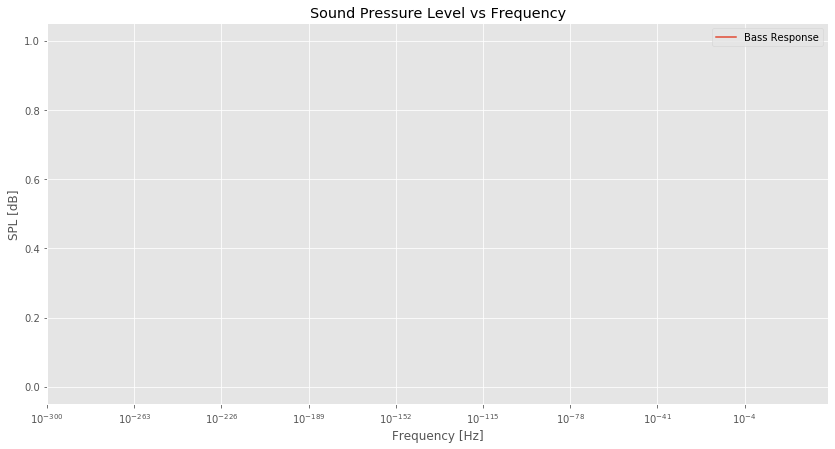

In [39]:
# Plot SPL
with plt.style.context('ggplot'): # Set style to be like R
    
    plt.figure(figsize=(14,7))
    plt.title('Sound Pressure Level vs Frequency')
    p1 = plt.semilogx(f,abs(SPL_br))
    plt.ylabel('SPL [dB]') 
    plt.xlabel('Frequency [Hz]') 
    plt.legend(['Bass Response'])
    
    
    # Style stuff below
    font = {'family': 'sans',
           'color':  'black',
           'weight': 'normal',
           'size': 16,
           }

In [ ]:
figure (1)
plt.loglog(f,abs(Qtot),'b');
grid on;
hold on;
loglog(f,abs(Qp),'r');
loglog(f,abs(Qd),'m');
xlim([1 1000]);
xlabel('Frequency (Hz)');
ylabel('Volume Velocity [m^3 / sec]');
legend('Qtot', 'Qp', 'Qd');
title('Volume Velocities vs Frequency');
pedit;

figure(2);
%SPL = 20*log10(abs(P)/20e-6); % Used for calculating bass reflex SPL 
load('bass_response_spl.mat'); % load bass reflex SPL for plotting
SPL_closed = 20*log10(abs(P)/20e-6);
semilogx(f,SPL,'r'); hold on;
semilogx(f,SPL_closed,'k');
grid on;
xlim([20 1000]);
ylim([50 100]);
xlabel('Frequency (Hz)');
ylabel('SPL dB');
legend('Bass Reflex', 'Closed Cabinet');
title('SPL vs Frequency');
pedit;